### Autores:  
Blanco García, Gabriel: gabriel.blanco@cunef.edu  
Ferrín Meilán, Michelle: michelle.ferrin@cunef.edu

## Colegio Universitario de Estudios Financieros
### Máster en Data Science para Finanzas
Madrid, diciembre de 2020

# Machine Learning para la asignación de crédito

<img src='https://www.lendingclub.com/asset/ls/wp-assets/wp-content/uploads/2017/05/LC-Logo-Official-min-1024x418.png?v=2017-05-17T10:05:03' style=height:400px>

## Objetivo del trabajo
La motivación de esta práctica es desarrollar un proyecto de Machine Learning con todas sus fases y poner en práctica lo aprendido durante las clases. Se parte de una base de datos de clientes del Lending Club, y se busca tratar y analizar los datos, y construir diferentes modelos para ayudar a la decisión de quién es sujeto de crédito. Se busca establecer, a priori, si un nuevo cliente es susceptible de terminar impagando el crédito. Para ello, se plantean y evalúan distintos modelos, teniendo en cuenta en todo momento cuales serán las variables disponibles en el momento en el que un nuevo cliente solicite un crédito.

Adiccionalmente, el código del trabajo debe estar lo suficientemente limpio y ordenado como para superar el test de código, que consistirá en recibir un nuevo dataset y disponer de 15 minutos para transformarlo y evaluar el modelo ganador sobre el.

# Lectura de los datos, preprocesamiento y análisis exploratorio

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

La lecutra se hace en 4 tramos, uno por cada uno de los datset que contienen los datos del caso. En total, las observaciones suman cerca de 890.000, y se disponen de 153 variables. A continuación se muestra una vista reducida del diccionario de datos

In [3]:
df = pd.read_excel (r'../data/raw/LCDataDictionary.xlsx') 
print (df)

               LoanStatNew                                        Description
0           acc_now_delinq  The number of accounts on which the borrower i...
1     acc_open_past_24mths         Number of trades opened in past 24 months.
2               addr_state  The state provided by the borrower in the loan...
3                 all_util              Balance to credit limit on all trades
4               annual_inc  The self-reported annual income provided by th...
..                     ...                                                ...
148      settlement_amount  The loan amount that the borrower has agreed t...
149  settlement_percentage  The settlement amount as a percentage of the p...
150        settlement_term  The number of months that the borrower will be...
151                    NaN                                                NaN
152                    NaN  * Employer Title replaces Employer Name for al...

[153 rows x 2 columns]


De todas estas variables, se realiza un cribado previo, puesto que la gran mayoría son varibales de clientes existentes de Lending Club relaccionadas con su actividad actual, y no se dispondrá de ellas en el momento en que el modelo esté en producción

A contuniación se seleccionan solo las variables que consideramos de interés. Se declara una función para abreviar el proceso

In [3]:
# Columnas que se van a utilizar: lineas por orden alfabetico
columnas_para_leer = ['addr_state', 'annual_inc', 'annual_inc_joint', 'application_type', 
                      'dti', 'dti_joint',
                      'emp_length', 'emp_title',
                      'grade',
                      'home_ownership', 
                      'installment', 'int_rate', 
                      'loan_amnt', 'loan_status', 'last_fico_range_high', 'last_fico_range_low',
                      'mort_acc',
                      'pub_rec', 'pub_rec_bankruptcies', 'purpose', 
                      'sec_app_fico_range_low', 'sec_app_fico_range_high',
                      'term', 'title',
                      'verification_status', 'verification_status_joint']

In [4]:
# Definición de la función para leer los archivos
def lectura (archivo):
    
    data = pd.read_csv(archivo, 
                       skiprows=1, # saltar primera fila
                       skipfooter=2,  # saltar dos ultimas filas 
                       engine='python',
                       usecols=columnas_para_leer)
    return data

In [5]:
# Lectura del primer archivo
path = '../data/raw/Loan_training_set_1_4.csv'
df1 = lectura(path)

In [6]:
df1.head() # comprobamos que la lectura es correcta, y procedemos a leer el resto de archivos

,loan_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,last_fico_range_high,last_fico_range_low,application_type,annual_inc_joint,dti_joint,verification_status_joint,mort_acc,pub_rec_bankruptcies,sec_app_fico_range_low,sec_app_fico_range_high
0,2300,36 months,12.62%,77.08,C,NaN,NaN,OWN,10000.0,Not Verified,...,704,700,Individual,NaN,NaN,NaN,0,0,NaN,NaN
1,16000,60 months,12.62%,360.95,C,teacher,10+ years,MORTGAGE,94000.0,Not Verified,...,709,705,Individual,NaN,NaN,NaN,7,0,NaN,NaN
2,6025,36 months,15.05%,209.01,C,Front Office,7 years,MORTGAGE,46350.0,Not Verified,...,664,660,Individual,NaN,NaN,NaN,2,0,NaN,NaN
3,20400,36 months,9.44%,652.91,B,Manager,10+ years,RENT,44000.0,Source Verified,...,744,740,Individual,NaN,NaN,NaN,0,0,NaN,NaN
4,13000,36 months,11.99%,431.73,B,Paramedic,10+ years,MORTGAGE,85000.0,Source Verified,...,669,665,Individual,NaN,NaN,NaN,1,0,NaN,NaN


In [8]:
# Comprobamos que hay dentro: 7 columnas de tipo float64, 6 de tipo int64 y 13 object 
df1.info() # Muchas columnas son de tipo object, esto puede dar problemas 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105451 entries, 0 to 105450
Data columns (total 26 columns):
loan_amnt                    105451 non-null int64
term                         105451 non-null object
int_rate                     105451 non-null object
installment                  105451 non-null float64
grade                        105451 non-null object
emp_title                    98669 non-null object
emp_length                   98754 non-null object
home_ownership               105451 non-null object
annual_inc                   105451 non-null float64
verification_status          105451 non-null object
loan_status                  105451 non-null object
purpose                      105451 non-null object
title                        105451 non-null object
addr_state                   105451 non-null object
dti                          105376 non-null float64
pub_rec                      105451 non-null int64
last_fico_range_high         105451 non-null int64
last_fi

In [9]:
df1.loan_status.unique() # Estado del préstamo, la variable dependiente 

array(['Current', 'Fully Paid', 'In Grace Period', 'Late (31-120 days)',
       'Late (16-30 days)', 'Charged Off', 'Default'], dtype=object)

In [10]:
# Lectura del segundo archivo
path = '../data/raw/Loan_training_set_2_4.csv'
df2 = lectura(path)

In [11]:
# Lectura del tercer archivo 
path = '../data/raw/Loan_training_set_3_4.csv'
df3 = lectura(path)

In [12]:
# Lectura del cuarto archivo
path = '../data/raw/Loan_training_set_4_4.csv'
df4 = lectura(path)

Una vez que hemos leído los datos por seprarado, los combinamos en un único dataframe

In [13]:
# Union de los datos
datos = pd.concat([df1, df2, df3, df4])

In [14]:
datos.head()

,loan_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,last_fico_range_high,last_fico_range_low,application_type,annual_inc_joint,dti_joint,verification_status_joint,mort_acc,pub_rec_bankruptcies,sec_app_fico_range_low,sec_app_fico_range_high
0,2300,36 months,12.62%,77.08,C,NaN,NaN,OWN,10000.0,Not Verified,...,704,700,Individual,NaN,NaN,NaN,0,0,NaN,NaN
1,16000,60 months,12.62%,360.95,C,teacher,10+ years,MORTGAGE,94000.0,Not Verified,...,709,705,Individual,NaN,NaN,NaN,7,0,NaN,NaN
2,6025,36 months,15.05%,209.01,C,Front Office,7 years,MORTGAGE,46350.0,Not Verified,...,664,660,Individual,NaN,NaN,NaN,2,0,NaN,NaN
3,20400,36 months,9.44%,652.91,B,Manager,10+ years,RENT,44000.0,Source Verified,...,744,740,Individual,NaN,NaN,NaN,0,0,NaN,NaN
4,13000,36 months,11.99%,431.73,B,Paramedic,10+ years,MORTGAGE,85000.0,Source Verified,...,669,665,Individual,NaN,NaN,NaN,1,0,NaN,NaN


In [15]:
datos.shape # Concatenación exitosa

(884876, 26)

Verificamos que no existen datos duplicados en el dataset

In [16]:
datos.duplicated().sum() 

0

Exploramos los formatos del dataset conjunto

In [17]:
datos.dtypes

loan_amnt                      int64
term                          object
int_rate                      object
installment                  float64
grade                         object
emp_title                     object
emp_length                    object
home_ownership                object
annual_inc                   float64
verification_status           object
loan_status                   object
purpose                       object
title                         object
addr_state                    object
dti                          float64
pub_rec                        int64
last_fico_range_high           int64
last_fico_range_low            int64
application_type              object
annual_inc_joint             float64
dti_joint                    float64
verification_status_joint     object
mort_acc                       int64
pub_rec_bankruptcies           int64
sec_app_fico_range_low       float64
sec_app_fico_range_high      float64
dtype: object

Hay variables que deberían tener formato numérico, como la del tipo de interés, y tienen formato object. Habrá que repararlas de cara a poder usarlas correctamente en los modelos. Todas las transformaciones deben englobarse en una función, que las aplique a los datos nuevos de cara a la puesta en prodcucción del modelo. Si los datos nuevos no coinicen con los datos de entrenamiento del modelo, el sistema caerá, algo que provocaría pérdidas indamisibles a cualquier empresa.

Exploramos la calidad de los datos, cuantas variables contienen NA's

In [18]:
(datos.isna().sum() / len(datos) * 100).round(2)

loan_amnt                     0.00
term                          0.00
int_rate                      0.00
installment                   0.00
grade                         0.00
emp_title                     5.95
emp_length                    5.79
home_ownership                0.00
annual_inc                    0.00
verification_status           0.00
loan_status                   0.00
purpose                       0.00
title                         0.01
addr_state                    0.00
dti                           0.03
pub_rec                       0.00
last_fico_range_high          0.00
last_fico_range_low           0.00
application_type              0.00
annual_inc_joint             97.59
dti_joint                    97.59
verification_status_joint    97.59
mort_acc                      0.00
pub_rec_bankruptcies          0.00
sec_app_fico_range_low       97.65
sec_app_fico_range_high      97.65
dtype: float64

Como se puede observar, existen múltiples variables que contienen un elevado porcentaje de NA's. Tras una investigación acera 
de dichas variables, decidimos __no eliminarlas__. El motivo es que la mayoría de variables son correspondientes a prestamos 
conjuntos, y el valor NA se produce cuando el prestamo es individual. Este tipo de conclusiones se tendrá en cuenta 
a la hora de construir los pipelines para los modelos, a la hora de imputar los valores nulos.  

Para el título del prestatario (emp_title) y los años de experiencia laboral, entendemos que los valores nulos hacen referencia 
a prestatarios sin titulo, y con 0 años de experiencia laboral, respectivamente. 

## Análisis exploratorio

Comenzamos el análisis explorando la variable dependiente

In [11]:
datos.loan_status.unique()

array(['Current', 'Fully Paid', 'In Grace Period', 'Late (31-120 days)',
       'Late (16-30 days)', 'Charged Off', 'Default'], dtype=object)

Hay categrorías que no tienen sentido. Current, por ejemplo, puesto que no sabemos qué va a pasar con esos prestatarios, si van a terminar pagando o no. Todas las variables cuyo loan status sea current, las eliminamos. 

Fully paid la vamos a considerar como que sí pagan, puesto que ya han terminado el crédito.  

En cuanto al periodo de gracia, se trata de un tiempo a partir del cual se permite pagar tarde, pero sin consecuencias, 
tipicamente 15 días (por eso late empieza en 16). Todo depende de lo restrictivos que queramos ser. En principio, 
lo consideramos como que no paga, puesto que nada nos garantiza que vaya a pagar.  

Las categorias tarde 16-30 y 31-120 también las consideramos como no pagadores. 
Charged Off se refiere a créditos que el prestamista cree que no va a poder cobrar, así que lo consideramos como no pagador.  

Default, evidentemente, es no pagador.

A continuación se transforma la columna 

In [15]:
# Eliminación de los current

# Primero creamos el filtro para todos los que no son current
no_current = (datos.loan_status != 'Current')

# Comprobamos que sirve para hacer el susbet
datos[no_current] 

# Actualizamos los datos
datos = datos[no_current]

In [16]:
# Para los valores de la fila, ahora sin current, se asigna el valor "Paga", si es "Fully paid", y "No paga" en caso
# contrario. 
datos.loan_status = datos.loan_status.map(lambda x: 'Paga' if x == 'Fully Paid' else 'No paga')

# Utilizamos función lambda porque la función es temporal y no merece la pena declararla fuera. 
# Map aplica la función a cada elemento de un objeto iterable, en este 
# caso una columna, y la expresión ternaria es equivalente a 
# if x == 'Fully Paid': 
#     return 'Paga' 
# else: 
#     return 'No paga'

datos.loan_status.unique() # Cambio realizado con éxito

array(['Paga', 'No paga'], dtype=object)

Se evalúa ahora si el problema está o no equilibrado.

In [36]:
calidad_prestamos = datos['loan_status'].value_counts() / len(datos) * 100
calidad_prestamos.round(2)

Paga       74.76
No paga    25.24
Name: loan_status, dtype: float64

El dataset no está totalmente equilibrado, aunque en principio el desequilibrio no parece grave.  Si los modelos presentan 
resultados pobres, quizá haya que aplicar operaciones de undersampling u oversampling.

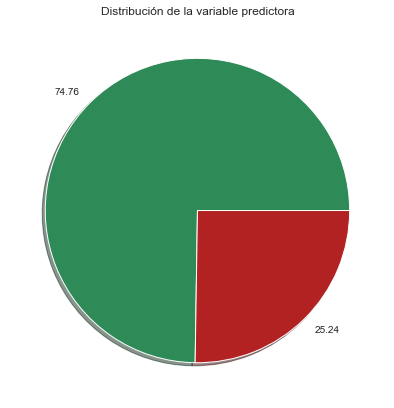

In [105]:
colores = ['seagreen', 'firebrick']
plt.subplots(figsize = (15, 7))

calidad_prestamos.plot.pie(shadow=True, 
                           colors=colores,
                          labels=[calidad_prestamos[0].round(2), calidad_prestamos[1].round(2)])
plt.title('Distribución de la variable predictora')
plt.ylabel(None);

## Explorando las variables predictoras 

### Histogramas del montante prestado y del tipo de interés

El tipo de interés viene en formato object, así que es necesario transformarlo a float para poder operar bien con el. eL procedimiento es el siguiente 
1. Se transforma la columna a formato string 
2. Se aplica el metodo de strings .rstrip() para extraer el signo del porcentaje 
3. Se tranforma a float con .astype('float')

In [17]:
datos['int_rate'] = datos['int_rate'].str.rstrip('%').astype('float')

A continuación los histogramas

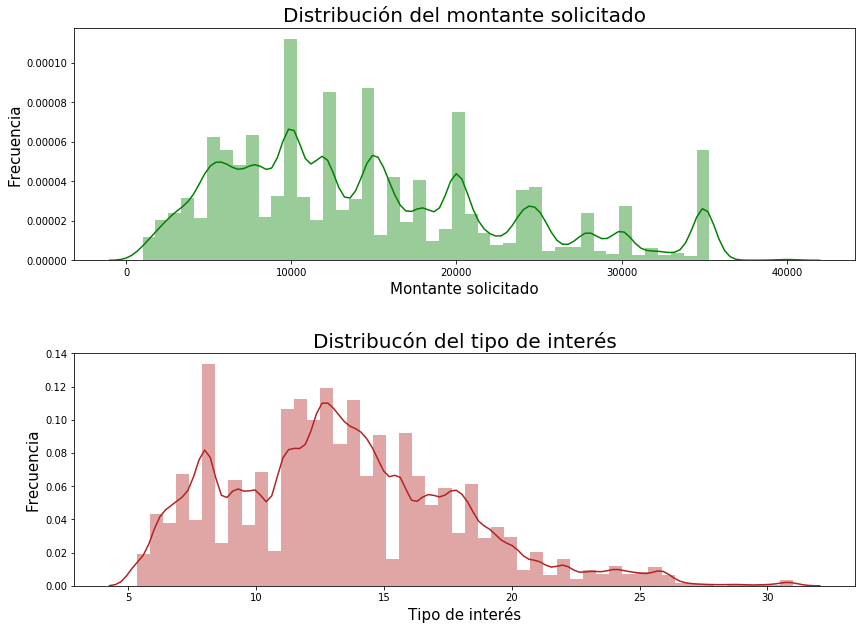

In [64]:
plt.figure(figsize=(14,10)) # dimensiones 

# Histograma del montante 
plt.subplot(211) # posición del primer plot 

g_montante = sns.distplot(datos.loan_amnt, color='green')
g_montante.set_xlabel('Montante solicitado', fontsize=15)
g_montante.set_ylabel('Frecuencia', fontsize=15)
g_montante.set_title('Distribución del montante solicitado', fontsize=20)

# Histograma del tipo de interés
plt.subplot(212)

g_interes = sns.distplot(datos.int_rate, color='firebrick')
g_interes.set_xlabel('Tipo de interés', fontsize=15)
g_interes.set_ylabel('Frecuencia', fontsize=15)
g_interes.set_title('Distribucón del tipo de interés', fontsize=20)

plt.subplots_adjust(hspace=0.4, top=0.9) # evitamos que los gráficos se pisenb

Respecto a la cantidad solicitada, se puede observar como el préstamo más habitual es el de 10.000 dólares, el grueso de los préstamos está entre 5.000 y 20.000 dólares.

En cuanto al tipo de interés, el grueso de los tipos varía entre el 7 y el 20%, llegando a tomar valores superiores al 25% en algunos casos.

###  Montante prestado en los diferentes estados

Primero creamos un dataset con los datos de interés agrupados por estado

## Tipo de interés y nota del crédito

El tipo de interés no es otra cosa que el coste financiero, el precio del dinero que se presta al prestatario. Para el prestatario es un coste, pero para el prestamista es rentabilidad. Cabría esperar que, ante perfiles con más riesgo de impago, 
el prestamista decida elevar el tipo del préstamo, para así poder compensar el riesgo extra asumido.   
Por este motivo, resulta conveniente explorar esta variable con respecto al impago, ya que representa el coste financiero, y tipos de interés más elevados pueden debilidar la capacidad de pago del prestatario, dificultando que devuelva el préstamo

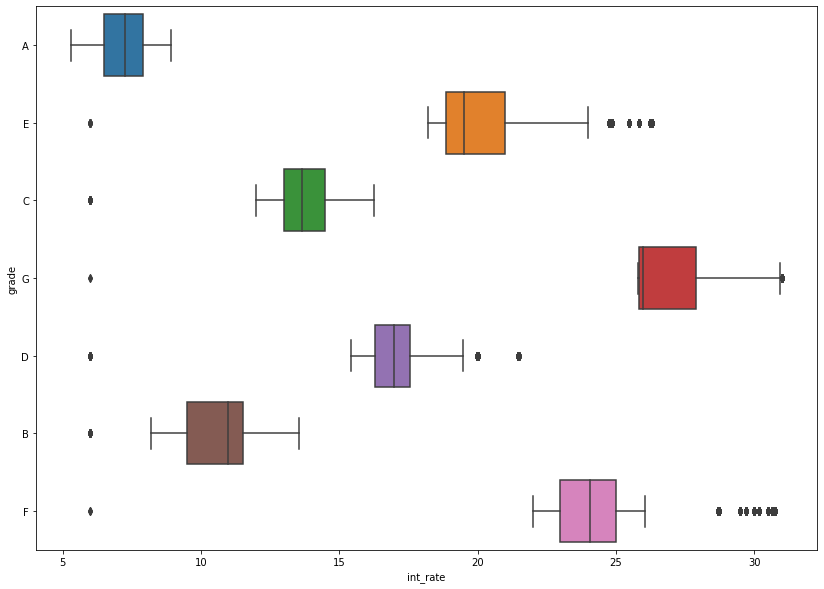

In [88]:
plt.figure(figsize=(14,10)) 

sns.boxplot(x='int_rate',
            y='grade', 
            data=datos);

In [114]:
# Tabla resumen

# Columnas de interés 
nota_credito = ['loan_status', 'grade']

# Paleta de color
color_tabla = sns.light_palette('red', as_cmap=True)

# Calculamos los valores con pd.crosstab
round(pd.crosstab(datos[nota_credito[0]], datos[nota_credito[1]], # las columnas a cruzar 
                  
                 values=datos['int_rate'], # valor = el tipo de interés
                  
                 # Usamos la mediana como función de agregación, dos decimales, y color en gradiente 
                 aggfunc='mean'), 2).style.background_gradient(cmap = color_tabla) 

grade,A,B,C,D,E,F,G
loan_status,,,,,,,
No paga,7.39,10.65,13.74,17.05,19.99,24.28,27.13
Paga,7.2,10.64,13.75,17,20.03,24.26,27.08


Vemos como el tipo de interés aumenta en fucnión del empeoramiento de la nota de crédito, y es algo más elevado, aunque no demasiado, en los no pagadores

### Distribución del tipode interés entre pagadores y no pagadores

Se emplea la mediana por su robustez ante valores extremos

In [82]:
datos.groupby(['loan_status']).int_rate.median()

loan_status
No paga    14.99
Paga       12.49
Name: int_rate, dtype: float64

Vemos como la mediana es algo superior en los casos en los que el crédito termina en default, aproximasamente un 2.5% superior.
Las distribuciones se visualizan con diagrama de caja y bigotes

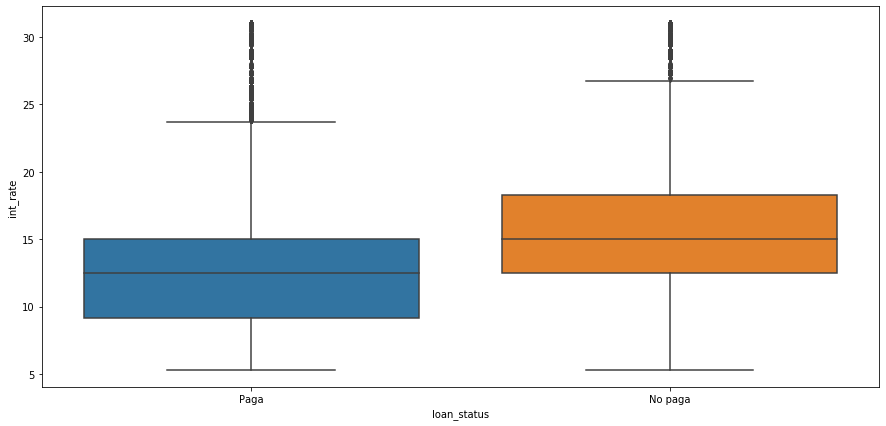

In [89]:
plt.subplots(figsize = (15, 7))

sns.boxplot(x='loan_status',
            y='int_rate',
            data=datos);

In [90]:
datos.groupby(['loan_status']).int_rate.describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
No paga,116671.0,15.443444,4.506846,5.32,12.49,14.99,18.24,30.99
Paga,345520.0,12.640187,4.299818,5.32,9.17,12.49,14.99,30.99


La distribución de tipos es superior en el caso de los no pagadores. Tanto la mediana como los cuartiles primero y tercero son superiores. 

### Correlaciones

¿Existe correlación entre las variables predictoras?

In [18]:
# Primero subset solo con variables numericas para calcular correlaciones 
datos_numericos = datos.select_dtypes(exclude=['object'])
correlaciones = datos_numericos.corr()

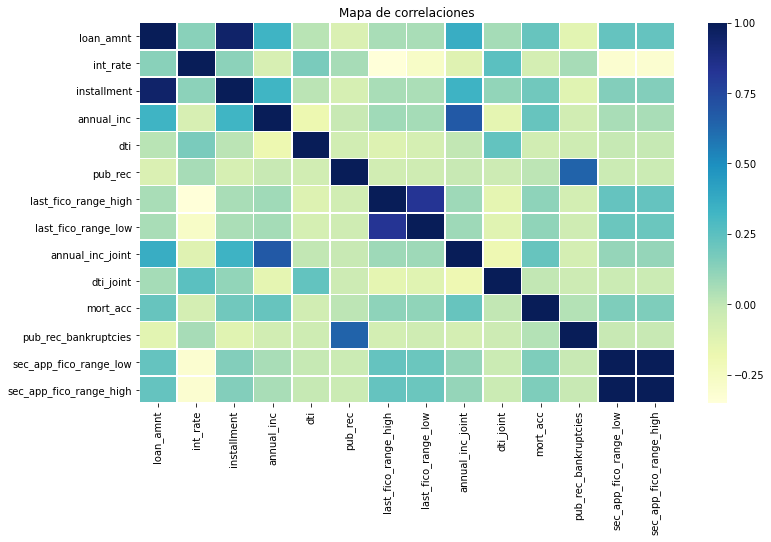

In [19]:
# Mapa de calor de las correlaciones.                       
f, ax = plt.subplots(figsize=(12, 7))

ax = sns.heatmap(
    correlaciones,  
    linewidths=.5, # separación entre cuadros
    cmap='YlGnBu') # escala de colores (yellow, green blue)
plt.title('Mapa de correlaciones');

El heat map de correlaciones muestra que no existen correlaciones llamativas, más que las obvias. No obstante, variables muy correlacionadas entre sí resultan redundantes, y pueden sobrecargar los modelos de manera innecesaria. Se puede observar un elevado nivel de correlación entre:
- Installement y loan amount: lógico, cuanto mayor sea el préstamo, mayor será la cuota mensual a pagar. Habrá que decidir entre una de estas dos variables
- Variables FICO: están muy correlacionadas entre sí, porque hacen referencia al rating FICO, que se da en forma de intervalo, con un valor superior y otro inferior. Sería interesante estudiar la creación de una variable conjunta, en la fase de ingeniería de varibales

###  Porcentaje de impago y propósito del préstamo

Otra variable a tener en cuenta es el proposito del préstamo, puesto que según a qué actividad se destine, se puede comprometer su devolución. Ciertos propóstios pueden ser más arriesgados que otros, como puede ser el ejemplo de un préstamo para actividades empresariales y un préstamo para una casa

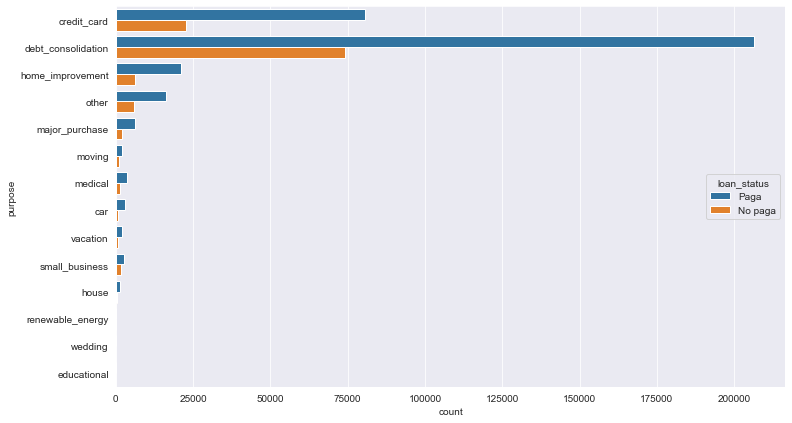

In [96]:
plt.subplots(figsize=(12, 7))

sns.countplot(y='purpose', 
            data=datos,
             hue='loan_status');

El gráfico anterior muestra la cantidad de pagos e impagos dentro de cada propósito. Sin embargo, está en valor absoluto, lo que imposibilita un buen estudio del impago. Se calculan los porcentajes a contuniación. Como la tabla se va a cosntruir para otras variables, se define una función. Se incluye el parámetro de los datos porque así existe la posibilidad de usar la 
función con otros datasets.

Primero se codifican las variables en el dataset (paga, no paga), y después se declara y se aplica la función

In [20]:
# Hacemos 'one hot encoding' para el loan status, y creamos dos columnas.

# Pagadores
datos['paga'] = datos.loan_status.map(lambda estado: 1 if estado == 'Paga' else 0) # Si paga, 1, si no, 0

# No pagadores
datos['no paga'] = datos.loan_status.map(lambda estado: 1 if estado == 'No paga' else 0) # si NO paga 1, si no, 0

In [21]:
# Definimos una función para el cálculo de los porcentajes

def tabla_impagos (datos, columna):
    """ 
    La función tomará dos argumentos: el dataframe, y la columna para la que se 
    desea obtener la tabla. El argumento con la columna ha de estar entre comillas 
    
    """
    
    # Agrupación por la columna deseada
    resultado =  datos.loc[:, [columna, 'paga', 'no paga']].groupby([columna]).sum()
    
    # Cálculo de la columna de total sumando filas
    resultado['total'] = resultado.loc[:,['paga', 'no paga']].sum(axis=1)
    
    # Cáuclulo de la columna del porcentaje 
    resultado['porcentaje_impago'] = (resultado['no paga'] / resultado.total * 100).round(2)
    
    # Se reinicia el índice de la tabla
    resultado.reset_index(inplace=True) 
    
    return resultado

In [160]:
# Aplicamos la función y exploramos el resultado 
impagos_proposito = tabla_impagos(datos, 'purpose')
impagos_proposito

,purpose,paga,no paga,total,porcentaje_impago
0,car,3116,779,3895,20.00
1,credit_card,80650,22599,103249,21.89
2,debt_consolidation,206274,74003,280277,26.40
3,educational,1,0,1,0.00
4,home_improvement,21229,6355,27584,23.04
5,house,1284,514,1798,28.59
6,major_purchase,6190,2053,8243,24.91
7,medical,3493,1278,4771,26.79
8,moving,2056,916,2972,30.82
9,other,16219,5900,22119,26.67


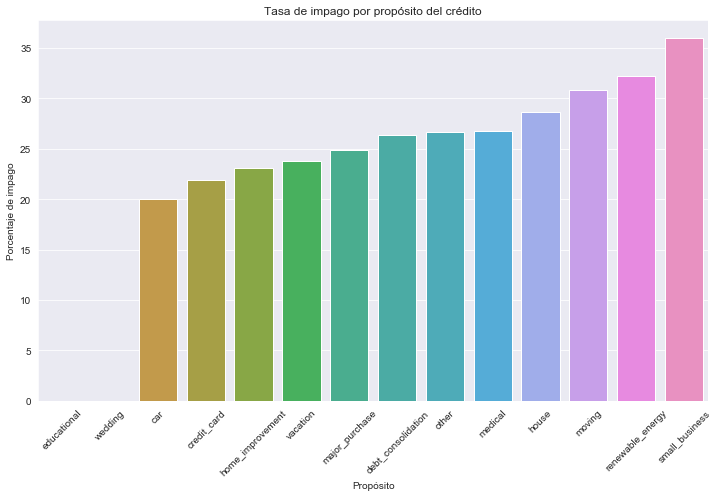

In [102]:
# Grafico del resultado 
plt.subplots(figsize=(12, 7))

sns.barplot(x='purpose', 
            y='porcentaje_impago',
           data=impagos_proposito,
           order=impagos_proposito.sort_values('porcentaje_impago').purpose) # eje x ordenado de menos a mas impago

plt.title('Tasa de impago por propósito del crédito')
plt.xlabel('Propósito')
plt.ylabel('Porcentaje de impago')
plt.xticks(rotation=45); # rotacion de las etiquetas del eje x, hay otro método? 

Podemos ver que la tasa de impago varía bastante en función del préstamo, llegando a superar el 35% en los préstamos a 
pequeños negocios. Puede ser interesante codificar esta variable en la fase de pipelines. No obstante, hay que tener en cuenta que hay categorías con impago 0, como el prestamo educacional de la que solo se cuenta con un registro. Las bodas representan 11 registros. Quizá sería conveniente eliminar estos 12 préstamos del dataset

También se define una función para los gráficos porcentuales, puesto que se usará en múltiples ocasiones

In [214]:
def barras_porcentuales(datos, eje_x, titulo, etiqueta_x):
    """
    La función  tomará como argunemtos los datos, la variable del eje x, el título y la etiqueta del eje x.
    La variable del eje y, por la forma en que se construyen las tablas, está siempre en el mismo lugar, así que 
    no hace falta que el usuario la escriba. La etiqueta del eje y es también siempre la misma
    """
    plt.subplots(figsize=(12, 7))
    
    sns.barplot(x=eje_x, # debe elegirla el usuario
                y='porcentaje_impago', # última columna del dataset, siempre se llama así
                data=datos) 
    
    plt.title(titulo)
    plt.xlabel(etiqueta_x)
    plt.ylabel('Porcentaje de impago');

A continuación, calculamos la tasa de impago para cada título profesional

In [162]:
impago_por_titulo = tabla_impagos(datos, 'emp_title')
impago_por_titulo

,emp_title,paga,no paga,total,porcentaje_impago
0,\tAdv Mtr Proj Fld Rep,1,0,1,0.0
1,\tEmployee Strategies Manager,1,0,1,0.0
2,letter carrier,0,1,1,100.0
3,Carpenter,0,1,1,100.0
4,Credit rev specialist,0,1,1,100.0
...,...,...,...,...,...
129442,zoning inspector,1,0,1,0.0
129443,zookeeper,1,1,2,50.0
129444,zs backroom,1,0,1,0.0
129445,Ã…Âšr. Technical Illustrator,1,0,1,0.0


In [163]:
# Ordenamos de mayor a menor % de impago para obtener las profesiones con mayor morosidad
impago_por_titulo.sort_values("porcentaje_impago", ascending = False)

,emp_title,paga,no paga,total,porcentaje_impago
77057,"RN, Director of Nursing",0,1,1,100.0
20997,Computer Information Technologist IV,0,1,1,100.0
115204,federal air marshal,0,1,1,100.0
115205,federal contract security officer,0,1,1,100.0
115206,federal law enforcement officer,0,1,1,100.0
...,...,...,...,...,...
51241,LTC Care Coordinator,1,0,1,0.0
51240,LTC - Personnel Management Officer,1,0,1,0.0
51239,LTC,1,0,1,0.0
51238,LT/O3-E,1,0,1,0.0


In [164]:
# Filtramos la tabla impagos_titulo para obtener aquellas profesiones con un porcentaje de impago del 100%
titulo_impago_100 = impago_por_titulo.porcentaje_impago == 100.0
impago_por_titulo[titulo_impago_100]

,emp_title,paga,no paga,total,porcentaje_impago
2,letter carrier,0,1,1,100.0
3,Carpenter,0,1,1,100.0
4,Credit rev specialist,0,1,1,100.0
5,Director,0,1,1,100.0
15,Administrator,0,1,1,100.0
...,...,...,...,...,...
129426,youth counslor,0,1,1,100.0
129429,youth security officer,0,1,1,100.0
129430,youth services worker,0,1,1,100.0
129434,zms fashion,0,1,1,100.0


De nuevo, el problema reside en que para cada tipo de empleo, se disponen de muy pocos datos. Que un director haya impagado 
no implica que todos los directores vayan a impagar. Por este motivo, descartamos esta variable.   
Además, incluso más importante es tener en cuenta que a la hora de aplicar encoding, una variable categórica generará tantas nuevas columnas como categorías tiene. En este caso, la columna tiene 129.447, y no parece buena idea añadir esa carga a los modelos, disparando el coste computacional. Otra opción sería utilizar un tipo de encoding distinto. Como primera aproximación, se descarta la variable

### Datos del registro público: amonestaciones y bancarrotas

Esta variable puede ser indicativa de que el prestatario es de riesgo. Analizamos los porcentajes de impago en cada una de las categorias 

In [168]:
registros_publicos = tabla_impagos(datos, 'pub_rec')
registros_publicos

,pub_rec,paga,no paga,total,porcentaje_impago
0,0,281948,93519,375467,24.91
1,1,53126,19036,72162,26.38
2,2,7022,2731,9753,28.00
3,3,2074,801,2875,27.86
4,4,657,313,970,32.27
5,5,325,125,450,27.78
6,6,163,77,240,32.08
7,7,80,23,103,22.33
8,8,52,16,68,23.53
9,9,21,7,28,25.00


In [169]:
bancarrotas = tabla_impagos(datos, 'pub_rec_bankruptcies')
bancarrotas

,pub_rec_bankruptcies,paga,no paga,total,porcentaje_impago
0,0,299208,100289,399497,25.10
1,1,43378,15188,58566,25.93
2,2,2289,940,3229,29.11
3,3,479,175,654,26.76
4,4,102,54,156,34.62
5,5,42,14,56,25.00
6,6,10,5,15,33.33
7,7,10,3,13,23.08
8,8,0,2,2,100.00
9,9,1,0,1,0.00


Obtenemos los gráficos utilizando la función previamente declarada

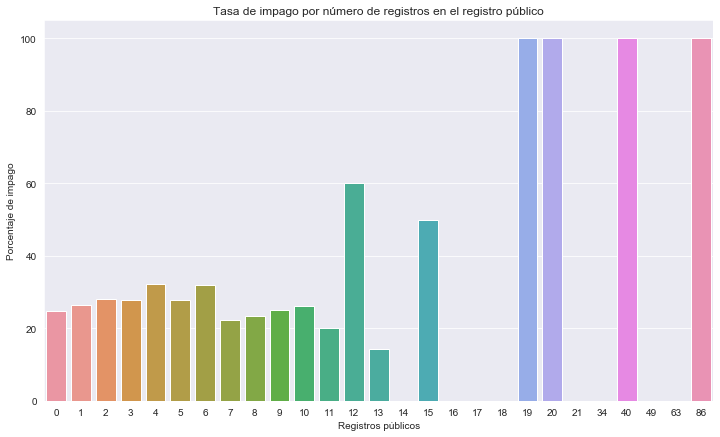

In [215]:
barras_porcentuales(datos=registros_publicos, 
                    eje_x='pub_rec', 
                    titulo='Tasa de impago por número de registros en el registro público',
                    etiqueta_x='Registros públicos')

Exceptuando el caso de los 13 registros públicos, se puede apreciar como a partir de 12, el impago se disapra. Puede ser interesante añadir una variable que codifique si hay más de 12 registros públicos o no en la fase de ingeniería de variables. Hacemos el mismo gráfico con las bancarrotas

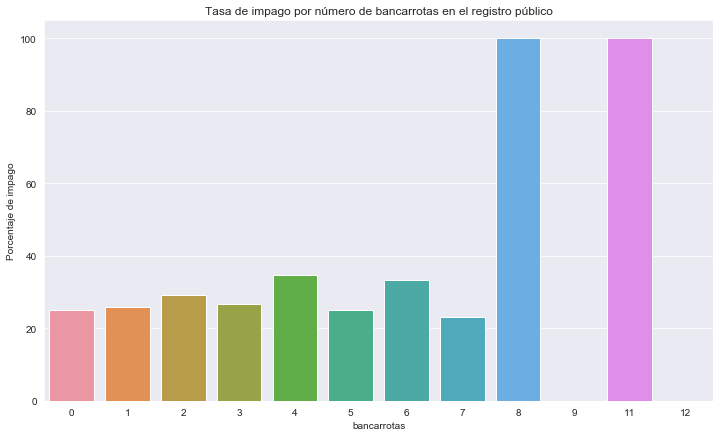

In [216]:
barras_porcentuales(datos=bancarrotas, 
                    eje_x='pub_rec_bankruptcies', 
                    titulo='Tasa de impago por número de bancarrotas en el registro público',
                    etiqueta_x='bancarrotas')

Igual que con el número de registros públicos, sería interesante crear una nueva variable que discrimine si el prestatario tiene mas de 4 quiebras. Sería interesante añadir pesos, en función de la frecuencia en el dataset

### Estado de verificacion 

In [188]:
estado = tabla_impagos(datos, 'verification_status')
estado

,verification_status,paga,no paga,total,porcentaje_impago
0,Not Verified,110346,25138,135484,18.55
1,Source Verified,139793,50822,190615,26.66
2,Verified,95381,40711,136092,29.91


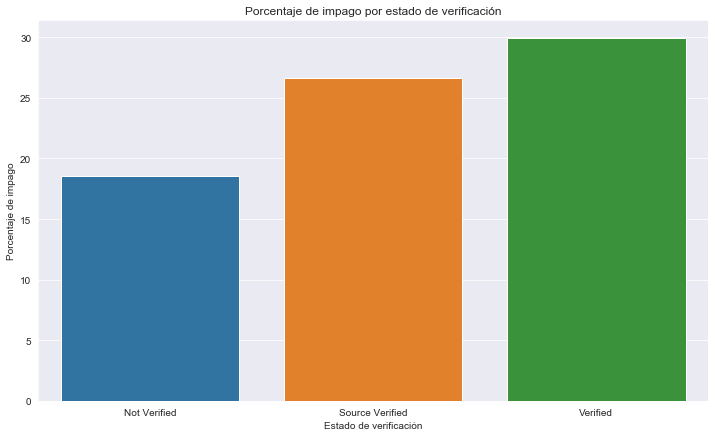

In [217]:
barras_porcentuales(datos=estado,
                    eje_x='verification_status',
                    titulo='Porcentaje de impago por estado de verificación',
                    etiqueta_x='Estado de verificación')

### Columnas FICO y grade

Calculamos la tasa de impago por la nota

In [193]:
impago_notas = tabla_impagos(datos, 'grade')
impago_notas

,grade,paga,no paga,total,porcentaje_impago
0,A,68708,5935,74643,7.95
1,B,102359,20644,123003,16.78
2,C,95699,35700,131399,27.17
3,D,48550,27784,76334,36.40
4,E,22165,18143,40308,45.01
5,F,6381,6476,12857,50.37
6,G,1658,1989,3647,54.54


Y su representación gráfica 

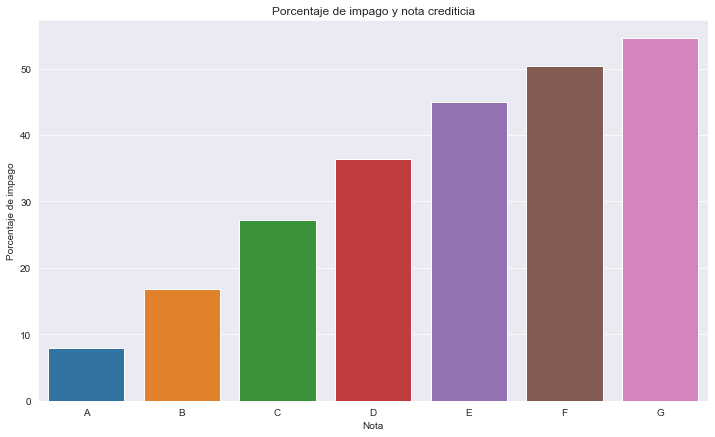

In [218]:
barras_porcentuales(datos=impago_notas, 
                    eje_x='grade',
                    titulo='Porcentaje de impago y nota crediticia',
                    etiqueta_x='Nota')

Esta variable está altamente relacionada con la tasa de impago. Vemos como a peores calificaciones, la tasa se eleva en gran medida. Se incluirá en el modelo 

### Préstamo conjunto 

Cabría esperar que en los préstamos conjuntos, el porcentaje de impago sea menor, puesto que el riesgo se reparte entre las partes.

In [225]:
prestamos_conjuntos = tabla_impagos(datos, 'application_type')
prestamos_conjuntos

,application_type,paga,no paga,total,porcentaje_impago
0,Individual,344607,115934,460541,25.17
1,Joint App,913,737,1650,44.67


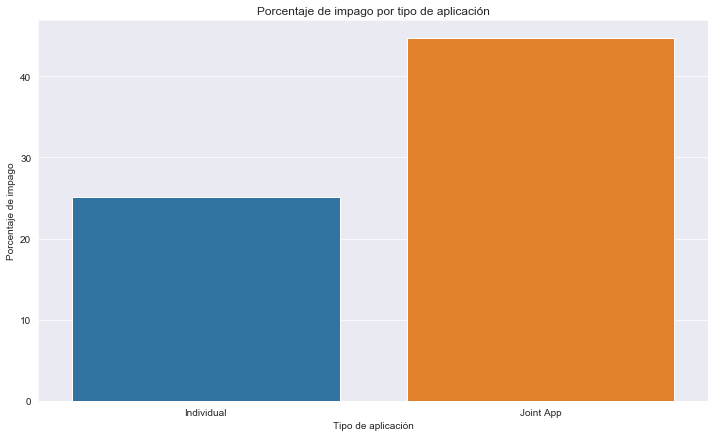

In [226]:
barras_porcentuales(datos=prestamos_conjuntos, 
                    eje_x='application_type',
                    titulo='Porcentaje de impago por tipo de aplicación',
                    etiqueta_x='Tipo de aplicación')

## Análisis notas fico

El análisis de estas variables se reserva para la parte de ingeniería de variables, puesto que va a haber que transformarla con toda seguridad

## Guardamos los datos limpios

In [22]:
datos.drop(['emp_title', 'title'], axis=1, inplace=True) # quitamos las redundantes

In [23]:
# Guardamos los datos pre procesados para la ingeniería de variables 
datos.to_csv('../data/intermediate/pre_clean_data.csv', index=False)